In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

In [7]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [9]:
datadir = '/cellar/users/snwright/Data/RareCommon/GWASAtlas'
figdir = '/cellar/users/snwright/Data/Transfer/RVC/figures/Figure_UKB_Inputs/'

## Load Data
### GWAS Atlas

In [10]:
info = pd.read_csv(os.path.join(datadir, 'gwasATLAS_v20191115.txt.gz' ), sep='\t', low_memory=False, index_col=0)
info.shape
info['ga_idx'] = [x for x in range(len(info))]
ukb_ids = ['UKB2 (EUR)', 'UKB1 (EUR)']
ukb_info = info[info.Population.isin(ukb_ids)]
# remove any with missing N
ukb_info = ukb_info[~ukb_info.N.isna()]
# remove any with missing Genome information
ukb_info = ukb_info[~ukb_info.Genome.isna()]
#restrict to those with at least 3 hits
ukb_info = ukb_info[ukb_info.Nhits >= 3]
cv_start = ukb_info.uniqTrait.nunique()
ukb_info = ukb_info.assign(trait_type=ukb_info.Ncase.apply(lambda x: 'CC' if x > 0 else 'Q'))

In [11]:

ukb_info.shape

(471, 30)

In [12]:
def extract_phecode(s):
    if isinstance(s, str):
        parts = [x for x in s.split('. ')]
        for p in parts:
            if 'UKB phenotype field' in p:
                return p.split(': ')[-1].split(' (')[0]
        else:
            return np.nan
    else:
        return np.nan
# extract ukb_phecodes where available in notes
ukb_info['phecode'] = ukb_info.Note.apply(lambda x: extract_phecode(x))

In [13]:
ukb_info['Trait'] = ukb_info['Trait'].apply(lambda x: x.lower())
ukb_info['uniqTrait'] = ukb_info['uniqTrait'].apply(lambda x: x.lower())

### Genebass

In [14]:
phenos = pd.read_csv(os.path.join(datadir,'../GeneBASS/', 'genebass_pheno_df_full.txt'), sep='\t', index_col=0)
phenos['description'] = phenos['description'].apply(lambda z: z.lower() if isinstance(z, str) else np.nan)
phenos['coding_description'] = phenos['coding_description'].apply(lambda z: z.lower() if isinstance(z, str) else np.nan)
phenos['n_controls'] = phenos['n_controls'].fillna(0)
phenos['N'] = phenos['n_cases'] + phenos['n_controls']
phenos['gb_idx'] = [x for x in range(len(phenos))]
phenos = phenos.dropna(subset='N')
phenos=phenos.sort_values(by='N', ascending=False)
phenos = phenos[phenos.trait_type != 'icd_first_occurrence']
rv_start = phenos.description.nunique()

In [15]:
phenos.nunique()

n_cases               1725
n_controls            1627
heritability          2459
saige_version            1
inv_normalized           1
trait_type               3
phenocode             1417
pheno_sex                3
coding                2057
modifier                 3
n_cases_defined       1809
n_cases_both_sexes    1796
n_cases_females       1572
n_cases_males         1435
description           1372
description_more      1213
coding_description    2147
category               117
N                      386
gb_idx                3849
dtype: int64

## Trait matching

### Direct PheCode matches

In [16]:
# first direct matches based on phecodes - do not use 'coding' from genebass will give incorrect matches
phe_match = phenos.merge(ukb_info, left_on='phenocode', right_on='phecode', how='inner')
phe_match.shape

(69, 51)

In [17]:
ga_match_ids = list(phe_match.ga_idx.values)

### SBERT trait matching

In [18]:
def get_all_matches(series1, series2, emb1, emb2, th=0.8):
    """
    Given two pandas Series (series1 and series2) along with their precomputed embeddings (emb1 and emb2),
    compute the cosine similarity between every string from series1 and every string from series2.
    
    Returns a DataFrame with all pairs (one string from each Series) having a cosine similarity >= th.
    Each row includes:
      - Series1_Index, Series1_Text,
      - Series2_Index, Series2_Text,
      - Cosine_Similarity.
    
    Parameters:
      series1 (pd.Series): Series of strings (with index) for list1.
      series2 (pd.Series): Series of strings (with index) for list2.
      emb1 (np.ndarray): Embeddings for the strings in series1 (assumed to correspond in order to series1.index).
      emb2 (np.ndarray): Embeddings for the strings in series2.
      th (float): Cosine similarity threshold (default=0.8).
    
    Returns:
      pd.DataFrame: DataFrame containing all unique pairs with similarity >= th.
    """
    # Compute the cosine similarity matrix between emb1 and emb2.
    sim_matrix = cosine_similarity(emb1, emb2)
    
    pairs = []
    # Loop over rows (series1) and columns (series2) to collect pairs meeting threshold.
    n1, n2 = sim_matrix.shape
    for i in range(n1):
        for j in range(n2):
            sim = sim_matrix[i, j]
            if sim >= th:
                pairs.append({
                    "Series1_Index": series1.index[i],
                    "Series1_Text": series1.iloc[i],
                    "Series2_Index": series2.index[j],
                    "Series2_Text": series2.iloc[j],
                    "Cosine_Similarity": sim
                })
    
    # Create DataFrame of matches.
    matches_df = pd.DataFrame(pairs)
    # (If the same pair could be found twice by any chance, drop duplicates.)
    matches_df.drop_duplicates(inplace=True)
    # Optionally, sort by descending similarity.
    matches_df.sort_values(by="Cosine_Similarity", ascending=False, inplace=True)
    return matches_df

In [19]:
# get the traits where we will use the description column
desc_counts = phenos.description.value_counts()
use_description = phenos[~phenos.description.isin(desc_counts[desc_counts>3].index.values)]
use_description = use_description[~use_description.description.isna()]
use_description.shape

(1378, 20)

In [20]:
# get embeddings
ga_embeddings = model.encode(list(ukb_info[~ukb_info.ga_idx.isin(ga_match_ids)]['Trait'].values), batch_size=32, show_progress_bar=True)
bass_embeddings1 = model.encode(use_description.description.values, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

In [21]:
ga_desc = get_all_matches(ukb_info[~ukb_info.ga_idx.isin(ga_match_ids)].set_index('ga_idx').Trait, 
                          use_description.set_index('gb_idx').description, 
                          ga_embeddings, bass_embeddings1, th=0.7)

In [22]:
use_coding = phenos[(~phenos.coding_description.isna()) & (~phenos.gb_idx.isin(use_description.gb_idx.values))]
bass_embeddings2 = model.encode(use_coding.coding_description.values, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/76 [00:00<?, ?it/s]

In [23]:
ga_coding = get_all_matches(ukb_info[~ukb_info.ga_idx.isin(ga_match_ids)].set_index('ga_idx').Trait, 
                          use_coding.set_index('gb_idx').coding_description, 
                          ga_embeddings, bass_embeddings2, th=0.7)

In [24]:
ga_all = pd.concat([ga_desc, ga_coding])
ga_all.columns = ['ga_idx', 'Trait', 'gb_idx', 'description', 'Cosine']
ga_all = ga_all[ga_all.Cosine>0.8]

In [25]:
phe_combined = phe_match.loc[:, ('ga_idx', 'Trait', 'gb_idx', 'description')]
phe_combined['Cosine'] = 1.0

In [33]:
all_matches = pd.concat([ga_all, phe_combined])


In [34]:
ukb_info_out = ukb_info[ukb_info.ga_idx.isin(all_matches.ga_idx.values)]
ukb_info_out = ukb_info_out.assign(Population= ukb_info_out.Population.map({'UKB1 (EUR)':'UKB1', 'UKB2 (EUR)':'UK2', 
                                                             'UKB2 (EUR meta)':'UKB2meta', 'UKB1 (EUR meta)':'UKB1meta'}))
ukb_info_out['StudyC'] = 'GA_idx'+ukb_info_out.ga_idx.astype(str) +'_'+ ukb_info_out.Population + '_' + ukb_info_out.PMID.astype(str)
ukb_info_out.drop_duplicates(subset=['PMID', 'Trait', 'Population']).shape

(103, 32)

In [35]:
phenos_out = phenos[phenos.gb_idx.isin(all_matches.gb_idx.values)]
phenos_out = phenos_out.assign(StudyR = 'GB_UKB_idx' + phenos_out.gb_idx.astype(str) + '_phe' + phenos_out.phenocode.astype(str))
phenos_out.shape

(162, 21)

In [36]:
all_matches = all_matches.merge(phenos_out.loc[:, ('gb_idx', 'StudyR', 'N')], on='gb_idx').merge(ukb_info_out.loc[:, ('ga_idx', 'StudyC', 'N')], on='ga_idx', suffixes=['_C', '_R'])

In [30]:
#all_matches = pd.read_csv('/cellar/users/snwright/Data/RareCommon/inputs/UKB/trait_matches_genebass_atlas_Mar21.txt', sep='\t')

In [37]:
all_matches_filtered = all_matches.sort_values(by=['Cosine', 'N_C'], ascending=False).drop_duplicates(subset='ga_idx')
all_matches_filtered = all_matches_filtered.sort_values(by=['Cosine', 'N_R'], ascending=False).drop_duplicates(subset='gb_idx')
all_matches_filtered
final_count = len(all_matches_filtered)

In [45]:
datadir

'/cellar/users/snwright/Data/RareCommon/GWASAtlas'

In [46]:
all_matches_filtered.to_csv('/cellar/users/snwright/Data/RareCommon/inputs/UKB/GB_GA_input_stats.tsv', sep='\t', index=False)

In [44]:
cv_start = 437
rv_start = 1372


1372

## Figures

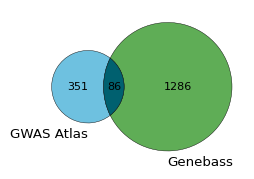

In [125]:
plt.rcParams.update({'font.size': 8})
_ = plt.figure(figsize=(3,2))
v = venn2(subsets=(cv_start-final_count,rv_start - final_count, final_count), set_labels=('GWAS Atlas', 'Genebass'))
v.get_patch_by_id('10').set_color('#6ec1e0')
v.get_patch_by_id('01').set_color('#5fad56')
v.get_patch_by_id('11').set_color('#00606f')
for patch in ['01', '10', '11']:
    v.get_patch_by_id(patch).set_alpha(1)
    v.get_patch_by_id(patch).set_ec('black')
    v.get_patch_by_id(patch).set_lw(0.3)
plt.savefig(os.path.join(figdir, 'trait_overlap_ukb_venn2.svg'), dpi=400, bbox_inches='tight')

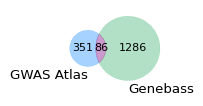

In [39]:
plt.rcParams.update({'font.size': 8})
_ = plt.figure(figsize=(2,1))
v = venn2(subsets=(cv_start-final_count,rv_start - final_count, final_count), set_labels=('GWAS Atlas', 'Genebass'))
v.get_patch_by_id('01').set_color('mediumseagreen')
v.get_patch_by_id('10').set_color('dodgerblue')
v.get_patch_by_id('11').set_color('purple')
plt.savefig(os.path.join(figdir, 'trait_overlap_ukb_venn2.svg'), dpi=400, bbox_inches='tight')

In [40]:
ukb_info_out.Domain.unique()


array(['Psychiatric', 'Metabolic', 'Skeletal', 'Cardiovascular',
       'Mortality', 'Activities', 'Environment', 'Respiratory',
       'Endocrine', 'Neoplasms', 'Body Structures', 'Reproduction',
       'Cognitive', 'Connective Tissue', 'Gastrointestinal',
       'Neurological'], dtype=object)

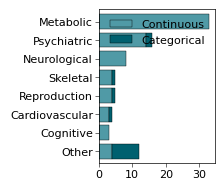

In [127]:
ukb_info_out = ukb_info_out[ukb_info_out.ga_idx.isin(all_matches_filtered.ga_idx.values)]
domains = ukb_info_out[ukb_info_out.trait_type=='Q'].Domain.value_counts().reset_index()
domains_plot = domains[domains['count']>=2]
other=domains[~domains.Domain.isin(domains_plot.Domain.values)]['count'].sum()
domain_dict =domains_plot.set_index('Domain')['count'].to_dict()
domain_dict['Other'] = other

domains = ukb_info_out[ukb_info_out.trait_type=='CC'].Domain.value_counts().reset_index()
domains_plot2 = domains[domains.Domain.isin(domains_plot.Domain.values)]
other2=domains[~domains.Domain.isin(domains_plot2.Domain.values)]['count'].sum()
domain_dict2 =domains_plot2.set_index('Domain')['count'].to_dict()
domain_dict2['Other'] = other2

_ = plt.figure(figsize=(1.5, 2))
pd.DataFrame({'Continuous': domain_dict, 'Categorical': domain_dict2}).iloc[::-1].plot(kind='barh', stacked=True, ax=plt.gca(),
                                                                              edgecolor='black', linewidth=0.3, width=0.8,
                                                                              color=[ '#509AA6', '#00606f',])
plt.xticks([0, 10, 20, 30])
plt.savefig(os.path.join(figdir, 'UKB_input_trait_types.svg'), bbox_inches='tight')

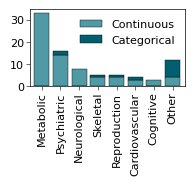

In [124]:
ukb_info_out = ukb_info_out[ukb_info_out.ga_idx.isin(all_matches_filtered.ga_idx.values)]
domains = ukb_info_out[ukb_info_out.trait_type=='Q'].Domain.value_counts().reset_index()
domains_plot = domains[domains['count']>=2]
other=domains[~domains.Domain.isin(domains_plot.Domain.values)]['count'].sum()
domain_dict =domains_plot.set_index('Domain')['count'].to_dict()
domain_dict['Other'] = other

domains = ukb_info_out[ukb_info_out.trait_type=='CC'].Domain.value_counts().reset_index()
domains_plot2 = domains[domains.Domain.isin(domains_plot.Domain.values)]
other2=domains[~domains.Domain.isin(domains_plot2.Domain.values)]['count'].sum()
domain_dict2 =domains_plot2.set_index('Domain')['count'].to_dict()
domain_dict2['Other'] = other2

_ = plt.figure(figsize=(2, 1))
pd.DataFrame({'Continuous': domain_dict, 'Categorical': domain_dict2}).plot(kind='bar', stacked=True, ax=plt.gca(),
                                                                              edgecolor='black', linewidth=0.3, width=0.8,
                                                                              color=[ '#509AA6', '#00606f',])
plt.yticks([0, 10, 20, 30])
plt.gca().tick_params(axis='x', rotation=90)
plt.savefig(os.path.join(figdir, 'UKB_input_trait_types_vertical.svg'), bbox_inches='tight')

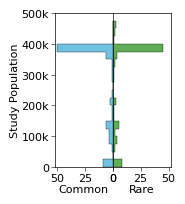

In [126]:
_, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(1.5, 2), sharey=True, gridspec_kw={'wspace':0})
bins=[x*25000 for x in range(0,  20)]
sns.histplot(y= all_matches_filtered.N_R, bins=bins, kde=False, element='step', ax=ax2, color='#5fad56', alpha=1, edgecolor='black')
sns.histplot(y= all_matches_filtered.N_C, bins=bins, kde=False, element='step', ax=ax1,color='#6ec1e0' , alpha=1, edgecolor='black')
ax1.invert_xaxis()
ax1.set_xlim(52, 0)
ax2.set_xlim(0, 52)
ax1.set_ylim(0, 500000)
_ = ax1.set_yticks([x*100000 for x in range(6)], labels=[0, '100k', '200k', '300k', '400k', '500k'])
ax1.set_ylabel('Study Population')
ax1.set_xticks([50, 25, 0])
ax2.set_xticks([0, 25, 50])
ax1.set_xlabel('Common')
ax2.set_xlabel('Rare')
ax2.tick_params(axis='y', size=0)
plt.savefig(os.path.join(figdir, 'population_size_histograms_ukb.svg'), bbox_inches='tight')

In [130]:
all_matches_filtered.to_csv('/cellar/users/snwright/Data/RareCommon/inputs/UKB/filtered_matched_traits.tsv', sep='\t')